In [1]:
import sys
import os, glob

home_dir = '/Users/rnogbodo/ML/raph_GNN' # replace with your own main folder path
sys.path.append(os.path.join(home_dir, "code"))

import os
from openpyxl import load_workbook
from openpyxl.styles import Font
from openpyxl.utils import get_column_letter
import seaborn as sns
from architecture import *
from utils import *
from training import *
from draw_molecules import *

import architecture, utils, training, draw_molecules
import importlib
importlib.reload(architecture)
importlib.reload(utils)
importlib.reload(training)
importlib.reload(draw_molecules)

/Users/rnogbodo/programs/miniconda3/envs/pytorch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'draw_molecules' from '/Users/rnogbodo/ML/raph_GNN/code/draw_molecules.py'>

In [2]:
device = prepare_system()
params = get_params_settings(yaml_params_path=params_path) 
params['DEVICE'] = device
print(device)

cuda:0


## Distribution of the predicted and target values

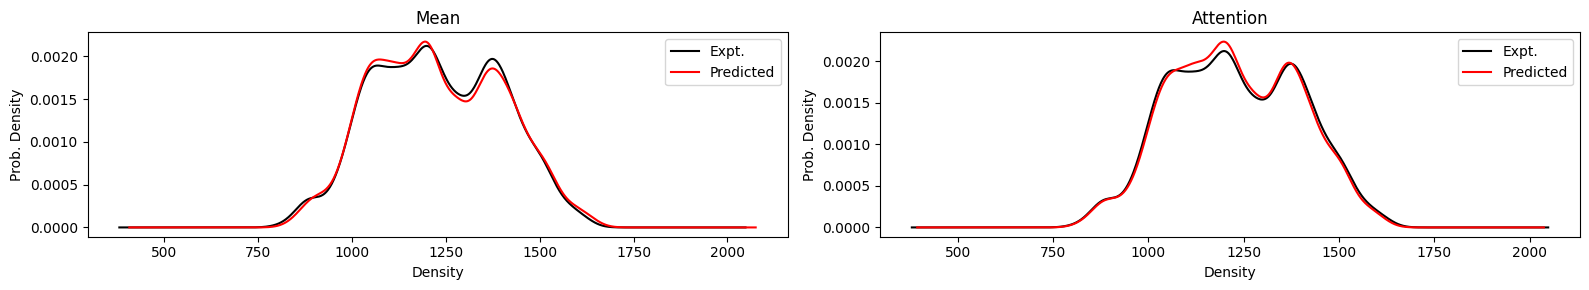

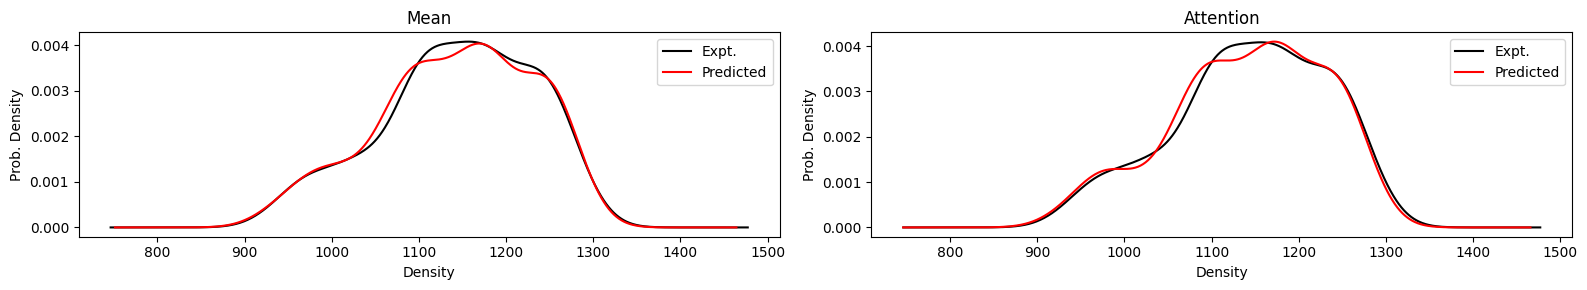

In [3]:
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


def create_dataframe(file):
    expt, pred = np.loadtxt(file, usecols=(0,1), unpack=True)
    df = pd.DataFrame({'Expt':expt, 'Predicted':pred})
    return df 

def plot(files):
    if len(files) < 2:
        fig, ax = plt.subplots(1, len(files), figsize=(5,3))
        file = files[0]
        df = create_dataframe(file)
        df['Expt'].plot(kind='kde', color='black', label='Expt.', ax=ax)
        df['Predicted'].plot(kind='kde', color='red', label='Predicted', ax=ax)
        ax.set_title(f"{file.split('-')[1].capitalize()}")
        ax.set_xlabel(f"{file.split('-')[2].capitalize()}")
        ax.set_ylabel(f"Prob. Density")
        ax.legend(loc='best')
    else:
        fig, ax = plt.subplots(1, len(files), figsize=(16,3))
        for i, file in enumerate(files):
            if os.path.exists(file):
                df = create_dataframe(file)
                df['Expt'].plot(kind='kde', color='black', label='Expt.', ax=ax[i])
                df['Predicted'].plot(kind='kde', color='red', label='Predicted', ax=ax[i])
                ax[i].set_title(f"{file.split('-')[1].capitalize()}")
                ax[i].set_xlabel(f"{file.split('-')[2].capitalize()}")
                ax[i].set_ylabel(f"Prob. Density")
                ax[i].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

prop = 'density'

# Trained ILs
files_nn = glob.glob(os.path.join(TEXTFILES, f'NN*{prop}-label-pred.txt'))
plot(files_nn)

# Transfer learned DES
files_trans_nn = glob.glob(os.path.join(TEXTFILES, f'tr*_NN*{prop}-label-pred.txt'))
plot(files_trans_nn)

## Parity and residual plots of the predicted vs the true target values for the test sets

/Users/rnogbodo/ML/raph_GNN/textfiles/NNConv-attention-density-label-pred.txt


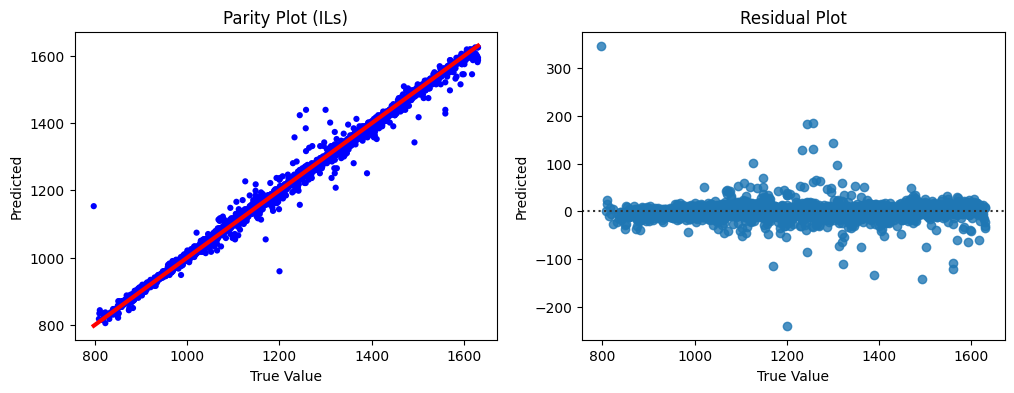

In [8]:
n = 1 # this number correspond to the index of the 'Predicted vs True value" files in "files_nn" based on the pooling method.

print(files_nn[n])
df = create_dataframe(files_nn[n])
fig, ax = plt.subplots(1,2,figsize=(12,4))

sns.scatterplot(x='Expt', y='Predicted', data=df, color='blue', marker='o',s=20, edgecolor='None', ax = ax[0])
ax[0].plot([df['Expt'].min(), df['Expt'].max()],[df['Expt'].min(), df['Expt'].max()], lw=3, label='y = x', color='red')
ax[0].set_title('Parity Plot (ILs)')
ax[0].set_xlabel('True Value')

sns.residplot(x='Expt', y='Predicted', data=df, ax=ax[1])
ax[1].set_title('Residual Plot')
ax[1].set_xlabel('True Value')

fig.savefig(os.path.join(Figures, 'IL-parity-plot.png'), transparent=True)
plt.show()

/Users/rnogbodo/ML/raph_GNN/textfiles/transfer_NNConv-attention-density-label-pred.txt


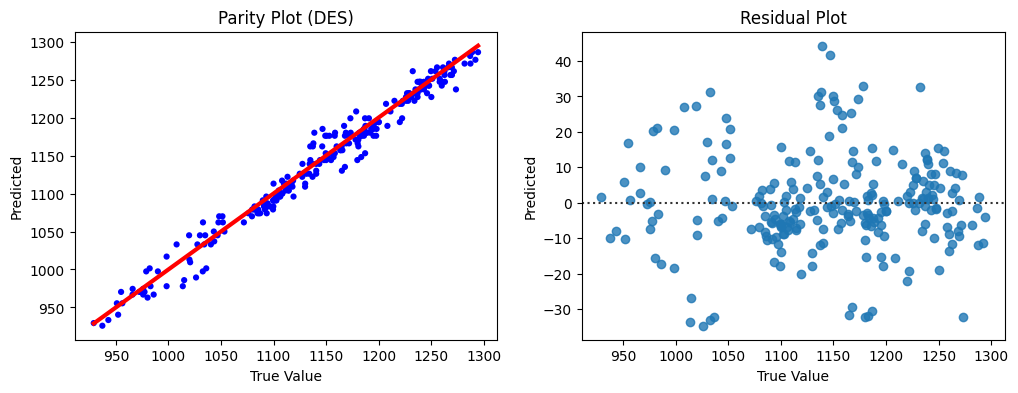

In [9]:
n = 1 # this number correspond to the index of the 'Predicted vs True value" files in "files_trans_nn" based on the pooling method.

print(files_trans_nn[n])
df = create_dataframe(files_trans_nn[n])
fig, ax = plt.subplots(1,2,figsize=(12,4))

sns.scatterplot(x='Expt', y='Predicted', data=df, color='blue', marker='o',s=20, edgecolor='None', ax = ax[0])
ax[0].plot([df['Expt'].min(), df['Expt'].max()], [df['Expt'].min(), df['Expt'].max()],lw=3, label='y = x', color='red')
ax[0].set_title('Parity Plot (DES)')
ax[0].set_xlabel('True Value')

sns.residplot(x='Expt', y='Predicted', data=df, ax=ax[1])
ax[1].set_title('Residual Plot')
ax[1].set_xlabel('True Value')

fig.savefig(os.path.join(Figures, 'DES-parity-plot.png'), transparent=True)
plt.show()

## **Here I will define the protocols for predicting properties giving a file containing ILs or DES**
#### Compulsory columns
1. smile 
2. teperature_K
3. pressure_MPa 
4. y (which could be values for density, viscosity, conductivity, refractive_index etc)
#### Columns that will be inserted automatically
5. numbered

In [10]:
filename = 'from-GNNs-data-density-clean.csv' # This file was gotten from https://pubs.acs.org/doi/suppl/10.1021/acs.iecr.9b00130/suppl_file/ie9b00130_si_001.zip
file = os.path.join(DATA, filename)
params['TARGET_FEATURE_NAME'] == 'density'

loaded_file = False
if os.path.splitext(os.path.basename(file))[1] == '.xlsx':
    df = pd.read_excel(file)
    if not df.empty: loaded_file = True
elif os.path.splitext(os.path.basename(file))[1] == '.csv':
    df = pd.read_csv(file)
    if not df.empty: loaded_file = True

print('Before Cleaning')
print(df.columns)
print(df.shape)

try:
    # Clean dataset
    to_drop = df[df['T_K'] > 388].index
    df = df.drop(to_drop).reset_index(drop=True)
    df = df.dropna().reset_index(drop=True)
    # Rename columns to what I used in my training
    df.rename(columns={'IL':'name','smiles':'smile', 'T_K':'temperature_K', 'P_MPa': 'pressure_MPa','d_kg*m-3':'y'}, inplace=True)
    remove_outliers(df, outlier_method='MAD')
    remove_unwanted_liquids(df, verbose=True)
except:
    df = df

numbered  = np.array(range(1, len(df)+1))
df['numbered'] = numbered
df['mol'] = df['smile'].apply(lambda x: Chem.MolFromSmiles(x) if x else None)

print('\nAfter Cleaning')
print(df.columns)
print(df.shape)

Before Cleaning
Index(['IL', 'cation', 'anion', 'd_kg*m-3', 'T_K', 'P_MPa', 'smiles'], dtype='object')
(41250, 7)

After Cleaning
Index(['name', 'cation', 'anion', 'y', 'temperature_K', 'pressure_MPa',
       'smile', 'formal_charge', 'numbered', 'mol'],
      dtype='object')
(38104, 10)


In [11]:
prop = 'density'
params['TARGET_FEATURE_NAME'] = prop
params['WHICH_LIQUID'] = 'predict'

if params['SCALE_CONDITIONS']:
    cond = '_'.join(params['CONDITION_NAMES'] ) if len(params['CONDITION_NAMES']) > 1 else params['CONDITION_NAMES'][0]
    if params['WHICH_LIQUID'] == 'il':
        feature_transformer = ConditionalScaler(scaler_type=params['SCALE_CONDITIONS_TYPE'], save_path=os.path.join(scaler_paths, f"{cond}_{params['TARGET_FEATURE_NAME']}-{params['SCALE_CONDITIONS_TYPE']}.pkl"))
    elif params['WHICH_LIQUID'] == 'des':
        feature_transformer = ConditionalScaler(scaler_type=params['SCALE_CONDITIONS_TYPE'], save_path=os.path.join(scaler_paths, f"des_{cond}_{params['TARGET_FEATURE_NAME']}-{params['SCALE_CONDITIONS_TYPE']}.pkl"))
    elif params['WHICH_LIQUID'] == 'predict':
        feature_transformer = ConditionalScaler(scaler_type=params['SCALE_CONDITIONS_TYPE'], save_path=os.path.join(scaler_paths, f"predict_{cond}_{params['TARGET_FEATURE_NAME']}-{params['SCALE_CONDITIONS_TYPE']}.pkl"))
        df = feature_transformer.fit_transform(df, params['CONDITION_NAMES'], df_test=None)
else:
    feature_transformer = None 

if params['FEATURE_TRANSFORM']:
    if params['WHICH_LIQUID'] == 'il':
        target_transformer = TargetTransformer(method=params['FEATURE_TRANSFORM_METHOD'], filename=os.path.join(scaler_paths, f"{params['TARGET_FEATURE_NAME']}_{params['FEATURE_TRANSFORM_METHOD']}.pkl"))
        target_transformer.load()
    elif params['WHICH_LIQUID'] == 'des':
        target_transformer = TargetTransformer(method=params['FEATURE_TRANSFORM_METHOD'], filename=os.path.join(scaler_paths, f"des_{params['TARGET_FEATURE_NAME']}_{params['FEATURE_TRANSFORM_METHOD']}.pkl"))
        target_transformer.load()
    elif params['WHICH_LIQUID'] == 'predict':
        target_transformer = TargetTransformer(method=params['FEATURE_TRANSFORM_METHOD'], filename=os.path.join(scaler_paths, f"predict_{params['TARGET_FEATURE_NAME']}_{params['FEATURE_TRANSFORM_METHOD']}.pkl"))
        target_transformer.fit(df[['y']])
        df['y'] = target_transformer.transform(df[['y']])
        target_transformer.save()
else:
    target_transforme = None

print(f"target_transformer: {target_transformer.transforms}")


Scaler saved to: /Users/rnogbodo/ML/raph_GNN/scalers/predict_temperature_K_pressure_MPa_density-log1p+robust.pkl
target_transformer: ['log1p', 'robust']


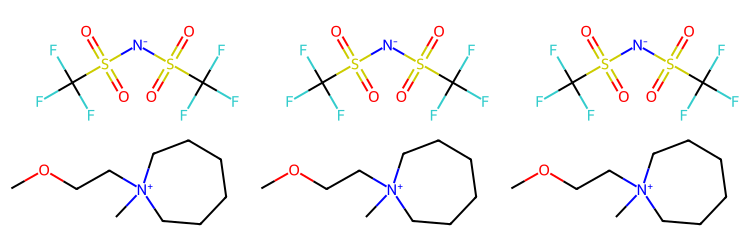

In [6]:
draw_molecule(df.smile.tolist()[3:6], molsPerRow=3)

In [61]:
params['PREDICT'] = True

if params['GLOBAL_FEATURES']:
    if params['NORM_GLOBAL_FEATURE']:
        if params['WHICH_LIQUID'] == 'il':
            glob_transformer = GlobTransformer(method=params['SCALE_CONDITIONS_TYPE'], filename=os.path.join(scaler_paths, f"{params['TARGET_FEATURE_NAME']}_global_features_transformer.pkl"))
        elif params['WHICH_LIQUID'] == 'des':
            glob_transformer = GlobTransformer(method=params['SCALE_CONDITIONS_TYPE'], filename=os.path.join(scaler_paths, f"des_{params['TARGET_FEATURE_NAME']}_global_features_transformer.pkl"))
        elif params['WHICH_LIQUID'] == 'predict':
            params['PREDICT'] = False
            glob_transformer = GlobTransformer(method=params['SCALE_CONDITIONS_TYPE'], filename=os.path.join(scaler_paths, f"predict_{params['TARGET_FEATURE_NAME']}_global_features_transformer.pkl"))

    data_list, df_gfeats = prepare_graph_data_from_mol(params, df, glob_transformer=glob_transformer, input_type='numpy', rbf_centers=None, rbf_gamma=10.0,allow_metal=True)
    GraphDataIO.save(data_list, os.path.join(DATA, f"{params['TARGET_FEATURE_NAME']}_predict_graphs.pkl.gz"), compress=params['COMPRESS'])
else:
    data_list = prepare_graph_data_from_mol(params, df, glob_transformer=None, cond_names=None, input_type='numpy', rbf_centers=None, rbf_gamma=10.0,allow_metal=True)
    GraphDataIO.save(data_list, os.path.join(DATA, f"{params['TARGET_FEATURE_NAME']}_predict_graphs.pkl.gz"), compress=params['COMPRESS'])

params['PREDICT'] = True

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38104/38104 [06:33<00:00, 96.83it/s]


Saved 38104 graphs to '/Users/rnogbodo/ML/raph_GNN/data/density_predict_graphs.pkl.gz' (compressed=True)


## **Here, I load data to be predicted and initialized and load model weights** 

In [12]:
# Here is a function to make predictions based on the saved .pkl.gz datasets (train, valid, test, and all_data) in the data folder
# Note only prop = density is available for which_liquid = 'des' at this time

def get_predictions(params=None, ARCH=None, prop=None, pooling_method=None,transfer=False, which_data=None):
    '''
    params: a parameter settings file saved as a .yaml file loaded as a dictionary in python
    ARCH:   the architecture to use (especially if multiple architectures were trained)
    prop:   the property to predict (viscosity, density, conductivity, or refractive_index)
    pooling_method: the pooling method used in the training depending on the one that replicates better the data distributions (mean, attention)
    transfer: True if you are using transfer model, False otherwise. Default is False
    which_data: the data category to be used (train, test, valid,all_data, or predict)
    Note: if params['WHICH_LIQUID'] == 'predict', then which_data must be 'predict'. If params['WHICH_LIQUID'] is either 'il' or 'des', which_data must be either 'train', 'test', v'alid', or 'all_data'.
    '''
    params['TARGET_FEATURE_NAME'] = prop
    if params['TARGET_FEATURE_NAME'] == 'refractive_index':
        params['CONDITION_NAMES'] = ['temperature_K', 'wavelength_nm']

    if params['TARGET_FEATURE_NAME'] == 'conductivity':
        params['CONDITION_NAMES'] = ['temperature_K']

    if params['TARGET_FEATURE_NAME'] == 'density' or params['TARGET_FEATURE_NAME'] == 'viscosity':
        params['CONDITION_NAMES'] = ['temperature_K', 'pressure_MPa']

    params['POOLING_METHOD'] = pooling_method
    params['ARCH'] = ARCH
    if params['WHICH_LIQUID'] == 'il':
        data_list = GraphDataIO.load(os.path.join(DATA,f"{params['TARGET_FEATURE_NAME']}_{which_data}_graphs.pkl.gz"))
        test_loader = GraphDataIO.load_to_dataloader(os.path.join(DATA, f"{params['TARGET_FEATURE_NAME']}_{which_data}_graphs.pkl.gz"), batch_size=params['NUM_GRAPHS_PER_BATCH'], shuffle=True)
        #ckpt_path = os.path.join(MODELS, f"{params['ARCH']}-{params['POOLING_METHOD']}-{params['TARGET_FEATURE_NAME']}-model_weights.pth")
    elif params['WHICH_LIQUID'] == 'des':
        data_list = GraphDataIO.load(os.path.join(DATA,f"des_{params['TARGET_FEATURE_NAME']}_{which_data}_graphs.pkl.gz"))
        test_loader = GraphDataIO.load_to_dataloader(os.path.join(DATA, f"des_{params['TARGET_FEATURE_NAME']}_{which_data}_graphs.pkl.gz"), batch_size=params['NUM_GRAPHS_PER_BATCH'], shuffle=True)
    elif params['WHICH_LIQUID'] == 'predict':
        data_list = GraphDataIO.load(os.path.join(DATA,f"{params['TARGET_FEATURE_NAME']}_{which_data}_graphs.pkl.gz"))
        test_loader = GraphDataIO.load_to_dataloader(os.path.join(DATA, f"{params['TARGET_FEATURE_NAME']}_{which_data}_graphs.pkl.gz"), batch_size=params['NUM_GRAPHS_PER_BATCH'], shuffle=True)
    
    if transfer:
        ckpt_path = os.path.join(MODELS, f"transfer_{params['ARCH']}-{params['POOLING_METHOD']}-{params['TARGET_FEATURE_NAME']}-model_weights.pth")
    else:
        ckpt_path = os.path.join(MODELS, f"{params['ARCH']}-{params['POOLING_METHOD']}-{params['TARGET_FEATURE_NAME']}-model_weights.pth")
    
    model = instantiate_model(params, data_list)
    
    if os.path.exists(ckpt_path):
        print("Loading checkpoint:", ckpt_path)
        load_checkpoint_into_encoder(model, ckpt_path, strict=False)

    if params['WHICH_LIQUID'] == 'il':
        target_transformer = TargetTransformer(method=params['FEATURE_TRANSFORM_METHOD'], filename=os.path.join(scaler_paths, f"{params['TARGET_FEATURE_NAME']}_{params['FEATURE_TRANSFORM_METHOD']}.pkl"))
    elif params['WHICH_LIQUID'] == 'des':
        target_transformer = TargetTransformer(method=params['FEATURE_TRANSFORM_METHOD'], filename=os.path.join(scaler_paths, f"des_{params['TARGET_FEATURE_NAME']}_{params['FEATURE_TRANSFORM_METHOD']}.pkl"))
    elif params['WHICH_LIQUID'] == 'predict':
        target_transformer = TargetTransformer(method=params['FEATURE_TRANSFORM_METHOD'], filename=os.path.join(scaler_paths, f"predict_{params['TARGET_FEATURE_NAME']}_{params['FEATURE_TRANSFORM_METHOD']}.pkl"))
    
    target_transformer.load()

    params["FINAL_EVAL_DATAFRAME"] = True # True because i need dataframe that contains relvant results i need
    original_y_test_np, original_y_pred_np, df_preds = final_eval_baseline(params, model, device, test_loader, transformer=target_transformer)

    if params['SCALE_CONDITIONS']:
        cond = '_'.join(params['CONDITION_NAMES'] ) if len(params['CONDITION_NAMES'] ) > 1 else params['CONDITION_NAMES'][0]
        if params['WHICH_LIQUID'] == 'il':
            feature_transformer = ConditionalScaler(scaler_type=params['SCALE_CONDITIONS_TYPE'], save_path=os.path.join(scaler_paths, f"{cond}_{params['TARGET_FEATURE_NAME']}-{params['SCALE_CONDITIONS_TYPE']}.pkl"))
        elif params['WHICH_LIQUID'] == 'des':
            feature_transformer = ConditionalScaler(scaler_type=params['SCALE_CONDITIONS_TYPE'], save_path=os.path.join(scaler_paths, f"des_{cond}_{params['TARGET_FEATURE_NAME']}-{params['SCALE_CONDITIONS_TYPE']}.pkl"))
        elif params['WHICH_LIQUID'] == 'predict':
            feature_transformer = ConditionalScaler(scaler_type=params['SCALE_CONDITIONS_TYPE'], save_path=os.path.join(scaler_paths, f"predict_{cond}_{params['TARGET_FEATURE_NAME']}-{params['SCALE_CONDITIONS_TYPE']}.pkl"))
        
        df_preds = feature_transformer.inverse_transform(df_preds, params['CONDITION_NAMES'])

    df_preds['percent_error'] = 100*(np.abs(df_preds['True_value'] - df_preds['Predicted_value'])/df_preds['True_value'])
    df_preds = df_preds.sort_values(by='percent_error').reset_index().drop(columns=['index'])
    return df_preds

df_preds = get_predictions(params=params, ARCH='NNConv', prop='density', pooling_method='mean',transfer=False, which_data='predict')

Loaded 38104 graphs from '/Users/rnogbodo/ML/raph_GNN/data/density_predict_graphs.pkl.gz'
Loaded 38104 graphs from '/Users/rnogbodo/ML/raph_GNN/data/density_predict_graphs.pkl.gz'
Created DataLoader with batch size 128


/Users/rnogbodo/programs/miniconda3/envs/pytorch_gpu/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Loading checkpoint: /Users/rnogbodo/ML/raph_GNN/models/NNConv-mean-density-model_weights.pth


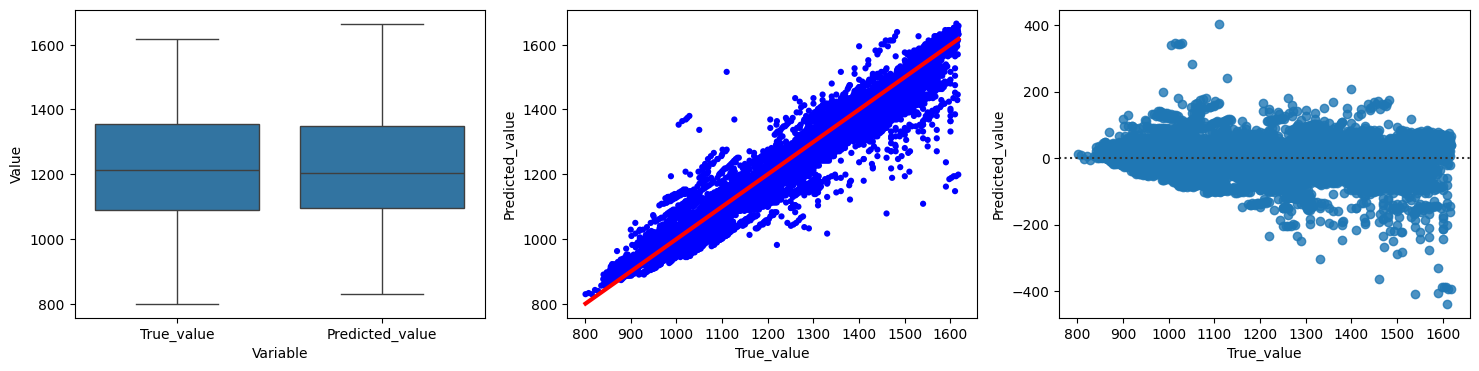

In [13]:
fig, ax = plt.subplots(1,3,figsize=(18,4))

df_long = df_preds[['True_value', 'Predicted_value']].melt(
    var_name='Variable',
    value_name='Value'
)
sns.boxplot(x='Variable', y='Value', data=df_long, ax=ax[0])

sns.scatterplot(x='True_value', y='Predicted_value', data=df_preds, color='blue', marker='o',s=20, edgecolor='None', ax = ax[1])
ax[1].plot([df_preds['True_value'].min(), df_preds['True_value'].max()],[df_preds['True_value'].min(), df_preds['True_value'].max()], lw=3, label='y = x', color='red')

sns.residplot(x='True_value', y='Predicted_value', data=df_preds, ax=ax[2])
plt.show()

In [14]:
# Print relevant metrics 
print_test_metrics(params, df_preds['True_value'].values, df_preds['Predicted_value'].values)


Final evaluation for Model NNConv-mean
Test : RMSE 29.268 ± 0.000 | MAE 16.604 ± 0.000 | R2 0.97 ± 0.00 | MARE 0.014 ± 0.000 | A20 1.00 ± 0.00


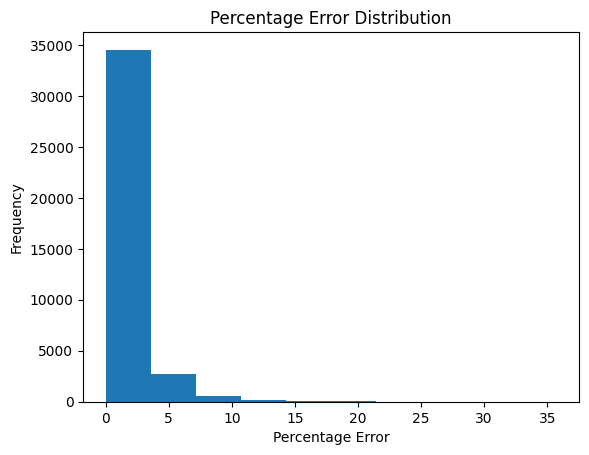

In [73]:
df_preds['percent_error'].plot(kind='hist')
plt.title('Percentage Error Distribution')
plt.xlabel('Percentage Error')
plt.show()

## Temperature dependent plots at constant pressure
### The model really captures the temperature and pressure dependent trends very well

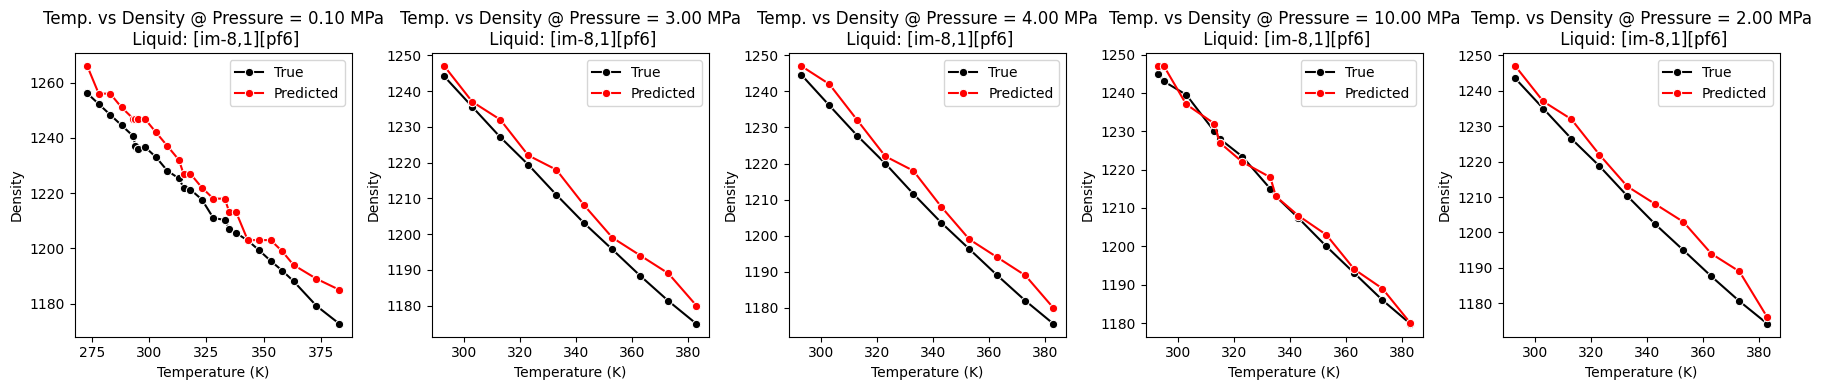

In [142]:
unique_entries = df_preds.name.unique() # Unique entries based on the component name in the given dataset 

name_indices = [0] # unique_entries index. Just keep it one index at a time
pressure_indices = range(0,5,1) # unique index for pressure if at different pressures. Maximum of 5 indices at a time

fig, ax = plt.subplots(1, len(pressure_indices), figsize=(18,4))
for n in name_indices:
    for i, m in enumerate(pressure_indices):
        if n < len(unique_entries):
            df_temp = df_preds[df_preds['name'] == unique_entries[n]].sort_values(by='temperature_K', ascending=True)
            df_temp['temperature_K'] = np.round(df_temp['temperature_K'],0)
            df_temp = df_temp.drop_duplicates(subset=['temperature_K', 'pressure_MPa'], keep='first')
            unique_pressure = df_temp['pressure_MPa'].unique()
            if m < len(unique_pressure):
                df_temp = df_temp[df_temp['pressure_MPa'] == unique_pressure[m]]
                sns.lineplot(x='temperature_K', y='True_value',data=df_temp, label='True', color='black', marker='o', ax=ax[i])
                sns.lineplot(x='temperature_K', y='Predicted_value', data=df_temp, label='Predicted', color='red',marker='o', ax=ax[i])
                ax[i].set_title(f'Temp. vs {prop.capitalize()} @ Pressure = {unique_pressure[m]:.2f} MPa\n Liquid: {unique_entries[n]}')
                ax[i].set_ylabel(f'{prop.capitalize()}')
                ax[i].set_xlabel('Temperature (K)')
                ax[i].legend()

for a in ax:
    if not a.has_data():
        fig.delaxes(a)

plt.tight_layout()
plt.show()

In [105]:
df_temp.head()

,True_value,Predicted_value,name,smile,temperature_K,pressure_MPa,percent_error
16032,1256.130005,1266.0,"[im-8,1][pf6]",CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F,273.0,0.1,0.785746
6214,1252.249878,1256.0,"[im-8,1][pf6]",CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F,278.0,0.1,0.299471
12626,1248.379883,1256.0,"[im-8,1][pf6]",CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F,283.0,0.1,0.610401
10839,1244.520020,1251.0,"[im-8,1][pf6]",CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F,288.0,0.1,0.520681
10602,1240.679688,1247.0,"[im-8,1][pf6]",CCCCCCCCn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F,293.0,0.1,0.509423


## A Look at predictions with over 5% Error

In [120]:

df_err = df_preds[df_preds['percent_error'] > 5].sort_values(by='percent_error', ascending=False)
df_err.head(30)

,True_value,Predicted_value,name,smile,temperature_K,pressure_MPa,percent_error
38103,1004.830139,1364.0,"[n-2,2][hso4]",CC[NH2+]CC.OS([O-])(=O)=O,328.149994,0.1,35.744336
38102,1020.540100,1385.0,"[n-2,2][hso4]",CC[NH2+]CC.OS([O-])(=O)=O,308.150024,0.1,35.712453
38101,1012.679810,1374.0,"[n-2,2][hso4]",CC[NH2+]CC.OS([O-])(=O)=O,318.149994,0.1,35.679608
38100,1023.970215,1385.0,"[n-2,2][hso4]",CC[NH2+]CC.OS([O-])(=O)=O,303.150055,0.1,35.257841
38099,1028.390137,1385.0,"[n-2,2][hso4]",CC[NH2+]CC.OS([O-])(=O)=O,298.149933,0.1,34.676515
38098,1110.000000,1475.0,"[im-3oh[2],1][pf6]",C[C@H](O)Cn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F,298.200012,0.1,32.882883
38097,1609.999634,1162.0,"[n-2,2,2][tfa]",CC[NH+](CC)CC.[O-]C(=O)C(F)(F)F,298.000061,0.1,27.826071
38096,1539.999634,1126.0,"[tc[im-4]im-10,10[im-4]][ntf2]",CCCC[n+]1ccn(CCCCCCCCCCn2cc[n+](CCCCCCCCCCn3cc[n+](CCCC)c3)c2)c1.FC(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,296.100037,0.1,26.883099
38095,1590.000000,1166.0,"[tc[p-3,3,3]im-3,3[p-3,3,3]][ntf2]",CCC[P+](CCC)(CCC)CCCn1cc[n+](CCC[P+](CCC)(CCC)CCC)c1.FC(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,296.100037,0.1,26.666667
38094,1609.999634,1185.0,"[im-4cn,1][cl]",Cn1cc[n+](CCCCC#N)c1.[Cl-],293.200012,0.1,26.397499


['C[C@H](O)Cn1cc[n+](C)c1.F[P-](F)(F)(F)(F)F', 'CC[NH2+]CC.OS([O-])(=O)=O', 'CC[NH2+]CC.OS([O-])(=O)=O']


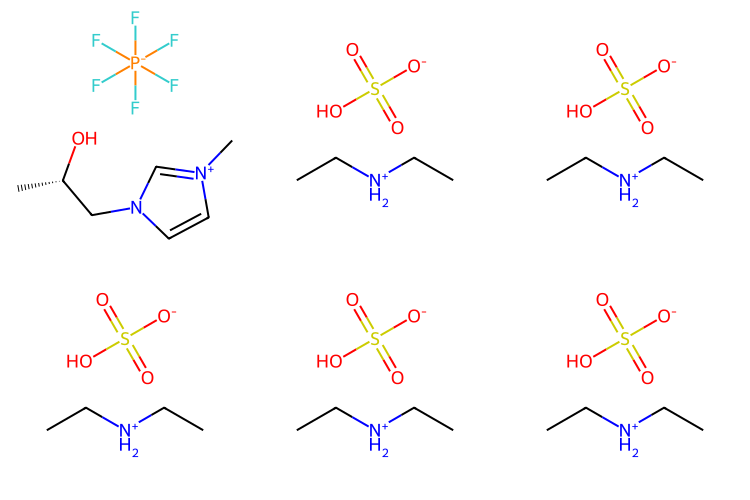

In [66]:
print(df_err.smile.tolist()[:3])
draw_molecule(df_err.smile.tolist()[0:6], molsPerRow=3)

## Here is a function that can color the points with significant errors

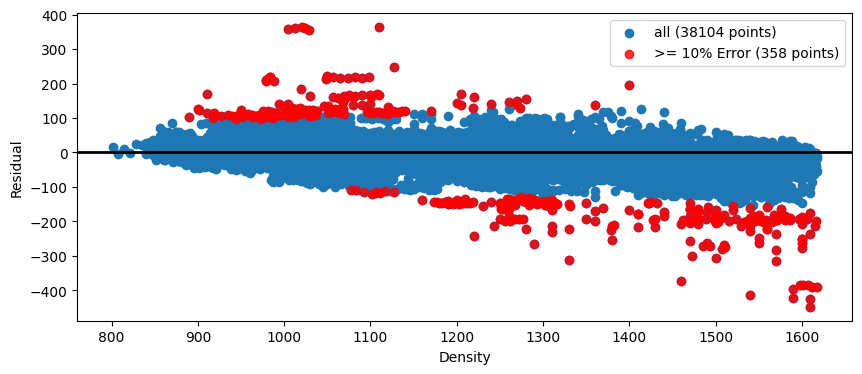

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def check_poor_preds(df, y_true, y_pred, percent_error_threshold=5):
    df['residual'] = df[y_pred] - df[y_true]

    df_error = df[df['percent_error'] >= percent_error_threshold]

    # residual plot
    plt.figure(figsize=(10,4))
    plt.scatter(df[y_true], df['residual'], alpha=1.0, label=f'all ({df.shape[0]} points)')
    plt.scatter(df_error[y_true], df_error['residual'], label=f'>= {percent_error_threshold}% Error ({df_error.shape[0]} points)',color='red', alpha=0.8)
    plt.axhline(0, color='k', lw=2)
    plt.ylabel('Residual')
    plt.xlabel(f'{prop.capitalize()}')
    plt.legend()
    plt.show()

check_poor_preds(df_preds, 'True_value', 'Predicted_value',percent_error_threshold=10)